# Modelos tradicionales en series de tiempo

In [1]:
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smtsa
import numpy as np
from pmdarima import arima
from pmdarima import utils
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import seasonal
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from scipy.stats import shapiro
from numpy import log



Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [2]:
sns.set_theme()
sns.set_context("paper")

## Base de datos

In [3]:
stock = 'TSLA'
TSLA_df = yf.download(stock, start="2020-01-01", end="2024-01-01") 
TSLA_df = pd.DataFrame(TSLA_df)

[*********************100%***********************]  1 of 1 completed


Se obtiene información histórica sobre el precio de la acción de Tesla, Inc. (TSLA) en un periodo de 1460 días, utilizando la librería Yahoo Finance. Los datos están configurados para una resolución diaria (`1d`), lo que significa que se recuperan los precios de apertura, el precio más alto y más bajo del día, el precio de cierre y el volumen de operaciones para cada día en ese intervalo de tiempo.

In [4]:
def date_format(date_h):
    return date_h.strftime('%d/%m/%Y')

La función `date_format` toma como entrada un objeto de tipo `datetime` y devuelve una cadena de texto con la fecha formateada en el formato `dd/mm/aaaa` (día/mes/año). 

### Análisis previo

In [5]:
TSLA_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


 Visualizamos los datos de las acciones de Tesla para un período de un año.

In [6]:
TSLA_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1006 non-null   float64
 1   High       1006 non-null   float64
 2   Low        1006 non-null   float64
 3   Close      1006 non-null   float64
 4   Adj Close  1006 non-null   float64
 5   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.0 KB


El DataFrame contiene 1006 registros de las acciones de Tesla (TSLA), cubriendo aproximadamente un año de operaciones. Incluye 6 columnas: precios de apertura, máximo, mínimo, cierre, cierre ajustado, volumen de acciones negociadas, sin valores nulos.

In [7]:
TSLA_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,209.199484,213.949515,204.067199,209.126371,209.126371,1.332191e+08
std,85.988785,87.686367,83.987942,85.797682,85.797682,8.862855e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,159.702499,161.952496,153.649998,160.210003,160.210003,7.707188e+07
50%,223.954994,229.125000,218.174995,223.489998,223.489998,1.071037e+08
75%,263.557503,268.260010,258.307510,262.967491,262.967491,1.577770e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


El análisis refleja una considerable volatilidad en los precios de las acciones de Tesla, con un rango amplio entre los valores mínimos y máximos. El volumen de negociación también ha sido muy variable, lo que indica períodos de alta actividad en el mercado. Los percentiles muestran que la mayoría de los precios de las acciones se sitúan en el rango de $160 a $264, aunque con eventos de precios mucho más bajos y más altos durante el periodo analizado

### La serie de los datos

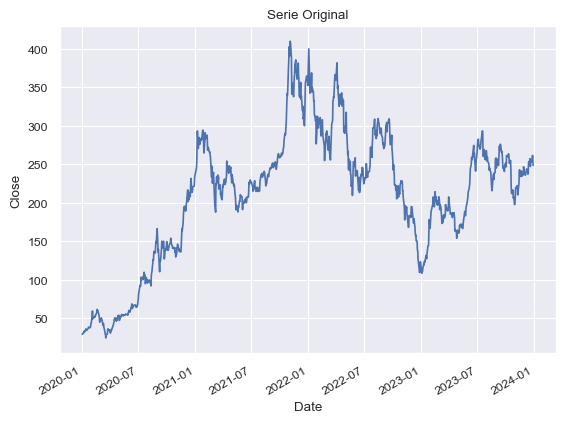

In [8]:
nlag = 45
TSLA_df['Close'].plot()
plt.title('Serie Original')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

Con el grafico siguiente las velas crecientes se dibujan en verde, mientras que las decrecientes se dibujan en rojo. Para realizar la figura usamos la función **Figure()** de la clase **go** de plotly, esta función recibe como input los datos asociados al candlestick suministrados por medio de la función **Candlestic** también de la clase **go** de plotly.

In [9]:
fig = go.Figure(data=[go.Candlestick(x=TSLA_df.index,  # Usamos TSLA_df.index para el eje x (fechas)
                                     open=TSLA_df['Open'], 
                                     high=TSLA_df['High'],
                                     low=TSLA_df['Low'], 
                                     close=TSLA_df['Close'])
                     ])
fig.update_layout(
    title="Tesla. (TSLA)",
    xaxis_title="Date",  
    yaxis_title="TSLA-USD",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="RebeccaPurple"
    )
)

fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()


Entre enero de 2020 y enero de 2024, los precios de cierre de las acciones de Tesla muestran una serie de fluctuaciones notables. A principios de 2020, el precio sufrió un descenso, pero comenzó a recuperarse a mediados de 2021, alcanzando un pico significativo. Sin embargo, el punto más alto se produjo a principios de 2022, seguido de una caída importante. Durante 2023, hubo un descenso considerable, antes de que el precio volviera a subir hacia finales de ese año. En 2024, se observa cierta estabilización en los precios, aunque no han vuelto a los niveles máximos alcanzados en 2022. La serie refleja una tendencia no estacionaria con picos y caídas abruptas a lo largo del período.

### Autocorrelación

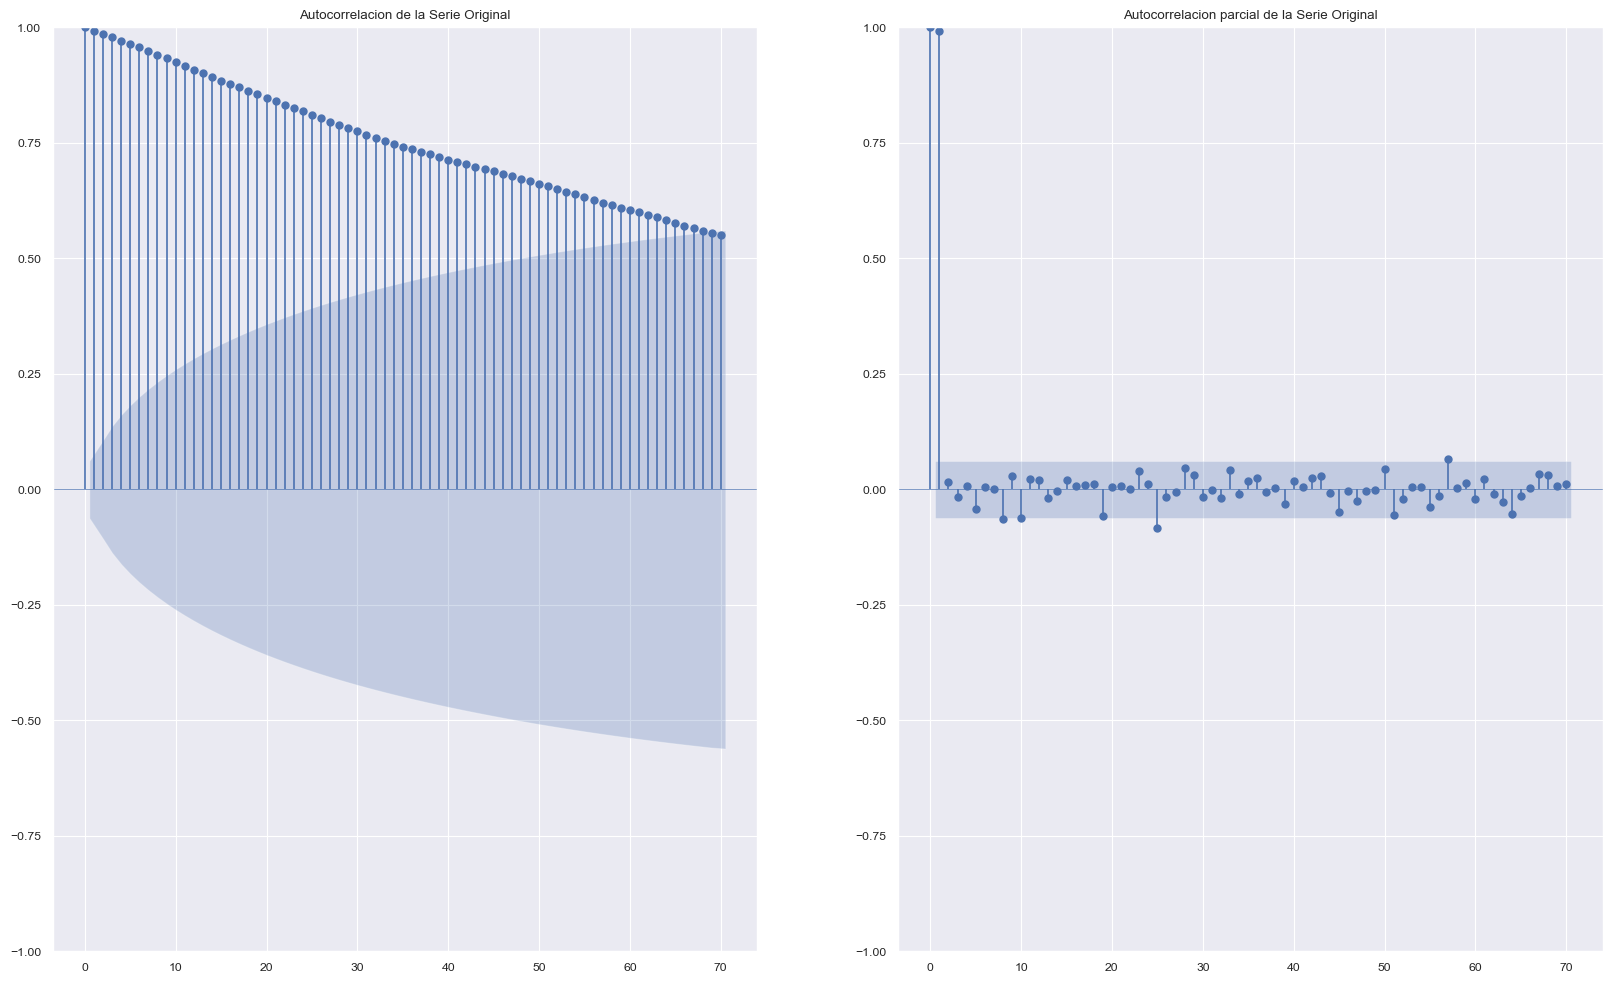

In [10]:
plt.rcParams.update({'text.usetex': False})
plt.rcParams.update({'figure.figsize': (20, 12)})

fig, axes = plt.subplots(1, 2, sharex=False)
nlag = 70

# Graficar ACF
plot_acf(TSLA_df["Close"], lags=nlag, linewidth=0.5, ax=axes[0])
axes[0].set_title('Autocorrelacion de la Serie Original')

# Graficar PACF
plot_pacf(TSLA_df["Close"], lags=70, linewidth=0.5, ax=axes[1])
axes[1].set_title('Autocorrelacion parcial de la Serie Original')

plt.show()

Los recuadros representan la dispersión entre los valores de apertura y cierre y las líneas representan la dispersión entre los valores bajos y altos. Los puntos de muestra en los que el valor de cierre es mayor (menor) que el de apertura se denominan crecientes (decrecientes).

### Estacionariedad

In [11]:
result = adfuller(TSLA_df.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.407545
p-value: 0.139618


Hipotesis inicial: la serie de tiempo no es estacionaria

No se rechaza la hipotesis inicial porque el p-value(0.139618) > 0.05, entonces se puede concluir que la serie **no es estacionaria**

# Modelo Arima

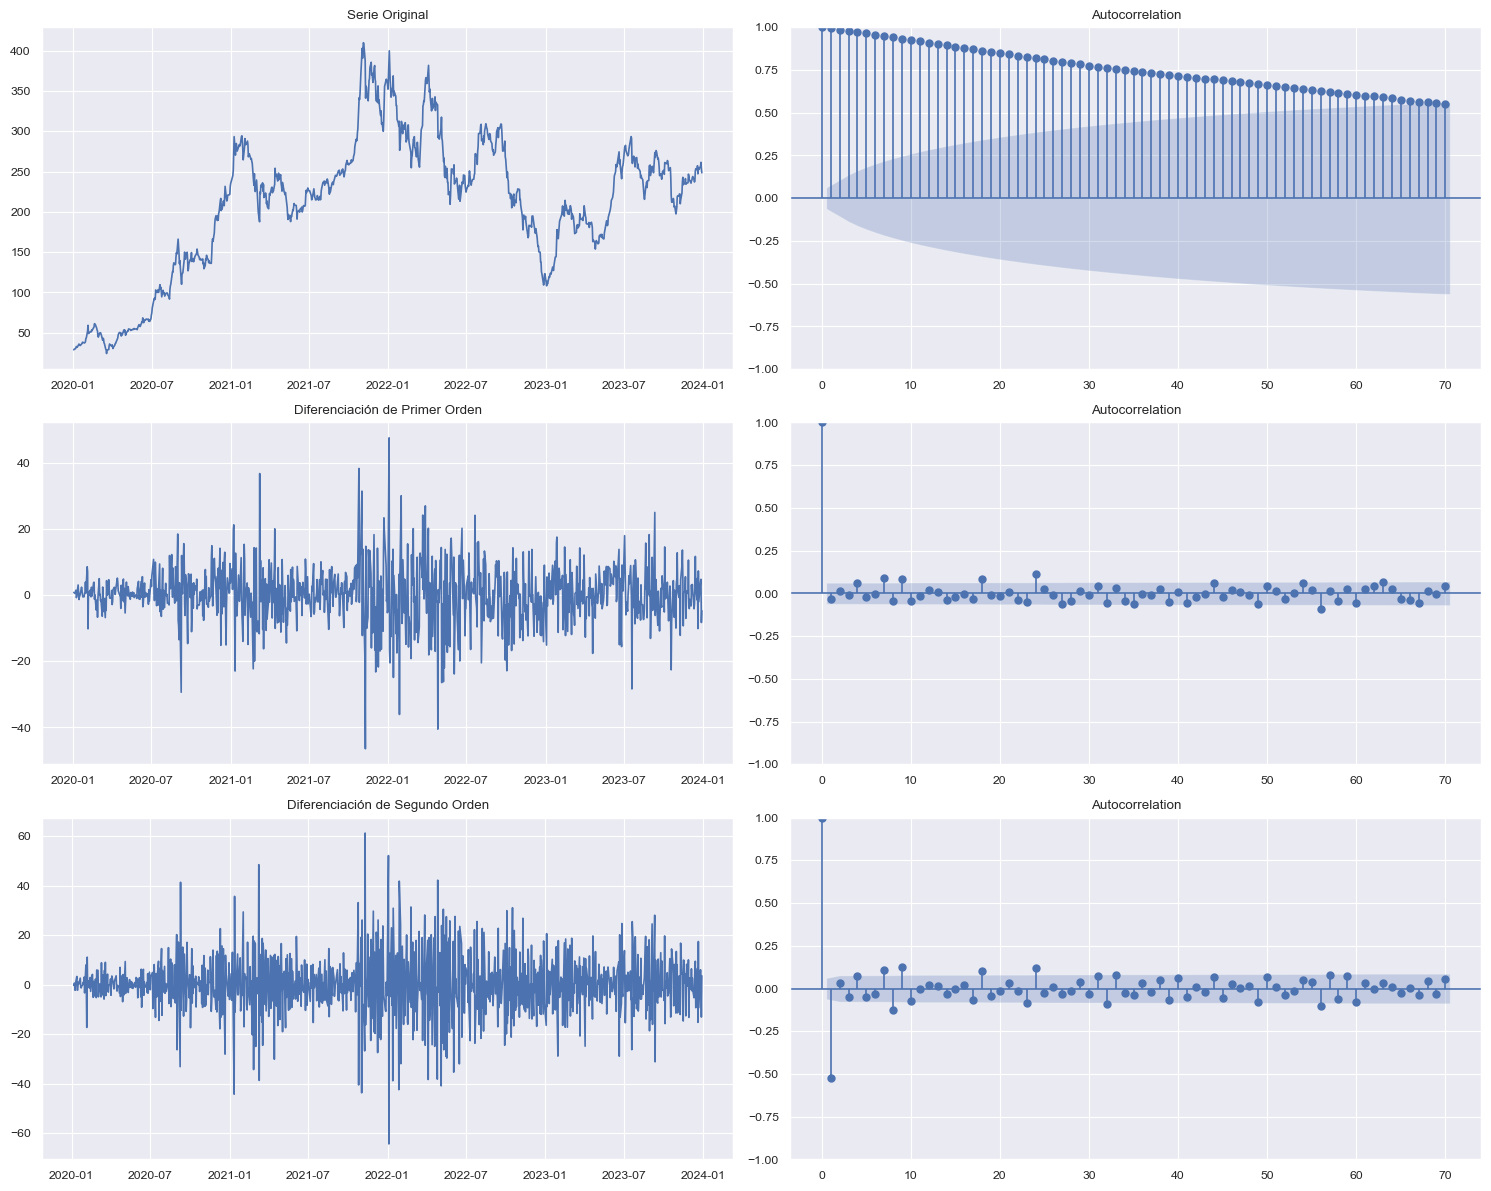

In [12]:
reset = TSLA_df.reset_index()

plt.rcParams.update({'figure.figsize': (15, 12)})

fig, axes = plt.subplots(3, 2)

axes[0, 0].plot(reset['Date'], reset['Close'])
axes[0, 0].set_title('Serie Original')
plot_acf(TSLA_df['Close'], ax=axes[0, 1], lags=70)

axes[1, 0].plot(reset['Date'], reset['Close'].diff())
axes[1, 0].set_title('Diferenciación de Primer Orden')
plot_acf(TSLA_df['Close'].diff().dropna(), ax=axes[1, 1], lags=70)

axes[2, 0].plot(reset['Date'], reset['Close'].diff().diff())
axes[2, 0].set_title('Diferenciación de Segundo Orden')
plot_acf(TSLA_df['Close'].diff().diff().dropna(), ax=axes[2, 1], lags=70)

plt.tight_layout()
plt.show()

Tras aplicar una diferenciación de segundo orden, se observa un cambio abrupto en la autocorrelación, pasando de positivo a negativo, lo que indica que la serie ha sido sobrediferenciada. Este fenómeno también se refleja en más valores fuera del intervalo de confianza del 95%, lo cual es otra señal de que se ha aplicado una diferenciación excesiva.

In [13]:
from sklearn.metrics import r2_score

In [14]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [15]:
def create_error_table(forecast, actual, str_name):

    errors = forecast_accuracy(forecast, actual, str_name)
    df_errors = pd.DataFrame(list(errors.items()), columns=['Métrica', 'Valor'])
    
    return df_errors

In [16]:
def evaluate_model(train, order):
    try:
        model = ARIMA(train, order=order).fit()
        return model.aic, model.bic, model.hqic
    except Exception as e:
        print(f"Error al ajustar el modelo con orden {order}: {e}")
        return np.inf, np.inf, np.inf

def find_best_arima_order(train):
    best_criteria = {'aic': np.inf, 'bic': np.inf, 'hqic': np.inf}
    best_orders = {'aic': None, 'bic': None, 'hqic': None}
    best_models = {'aic': None, 'bic': None, 'hqic': None}

    pq_rng = range(5)
    d_rng = range(3)

    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                order = (p, d, q)
                aic, bic, hqic = evaluate_model(train, order)
                
                if aic < best_criteria['aic']:
                    best_criteria['aic'] = aic
                    best_orders['aic'] = order
                    best_models['aic'] = (aic, bic, hqic)
                
                if bic < best_criteria['bic']:
                    best_criteria['bic'] = bic
                    best_orders['bic'] = order
                    best_models['bic'] = (aic, bic, hqic)
                
                if hqic < best_criteria['hqic']:
                    best_criteria['hqic'] = hqic
                    best_orders['hqic'] = order
                    best_models['hqic'] = (aic, bic, hqic)

    return {
        'best_order_aic': best_orders['aic'],
        'best_aic': best_criteria['aic'],
        'best_order_bic': best_orders['bic'],
        'best_bic': best_criteria['bic'],
        'best_order_hqic': best_orders['hqic'],
        'best_hqic': best_criteria['hqic']
    }

## Test 28: AIC, BIC, HQIC

### Arima con rolling

In [17]:
n = len(TSLA_df['Close']); n_test = 28; train_size = n - n_test

train = TSLA_df['Close'][:train_size]
dates_train = TSLA_df.index[:train_size]

test = TSLA_df['Close'][train_size:train_size + n_test] 
dates = TSLA_df.index[train_size:train_size + n_test] 

print("train:", train.shape)
print("test:", test.shape)

train: (978,)
test: (28,)


In [18]:
results = find_best_arima_order(train)
print(f"Mejor orden AIC: {results['best_order_aic']}, AIC: {results['best_aic']}")
print(f"Mejor orden BIC: {results['best_order_bic']}, BIC: {results['best_bic']}")
print(f"Mejor orden HQIC: {results['best_order_hqic']}, HQIC: {results['best_hqic']}")

Mejor orden AIC: (4, 1, 2), AIC: 6974.426729165991
Mejor orden BIC: (0, 1, 0), BIC: 6990.263632822838
Mejor orden HQIC: (3, 1, 2), HQIC: 6985.979631803315


In [19]:
def arima_rolling(history, test, best_order):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [20]:
yhat_4w  = arima_rolling(list(train), test.tolist(), results['best_order_aic'])

predicted=233.652269, expected=235.600006
predicted=236.309888, expected=241.199997
predicted=240.336477, expected=234.210007
predicted=234.666241, expected=235.449997
predicted=235.627730, expected=236.080002
predicted=235.939254, expected=246.720001
predicted=246.141271, expected=244.139999
predicted=245.029395, expected=240.080002
predicted=239.431214, expected=238.830002
predicted=239.459298, expected=235.580002
predicted=235.447180, expected=238.720001
predicted=238.060975, expected=239.369995
predicted=240.235598, expected=242.639999
predicted=241.932216, expected=243.839996
predicted=244.012068, expected=239.740005
predicted=240.198119, expected=237.009995
predicted=236.525625, expected=239.289993
predicted=239.566337, expected=251.050003
predicted=250.839651, expected=253.500000
predicted=253.252679, expected=252.080002
predicted=252.403087, expected=257.220001
predicted=257.582613, expected=247.139999
predicted=246.756783, expected=254.500000
predicted=254.289285, expected=252

In [21]:
yhat_bic = arima_rolling(list(train), test.tolist(), results['best_order_bic'])

predicted=234.300003, expected=235.600006
predicted=235.600006, expected=241.199997
predicted=241.199997, expected=234.210007
predicted=234.210007, expected=235.449997
predicted=235.449997, expected=236.080002
predicted=236.080002, expected=246.720001
predicted=246.720001, expected=244.139999
predicted=244.139999, expected=240.080002
predicted=240.080002, expected=238.830002
predicted=238.830002, expected=235.580002
predicted=235.580002, expected=238.720001
predicted=238.720001, expected=239.369995
predicted=239.369995, expected=242.639999
predicted=242.639999, expected=243.839996
predicted=243.839996, expected=239.740005
predicted=239.740005, expected=237.009995
predicted=237.009995, expected=239.289993
predicted=239.289993, expected=251.050003
predicted=251.050003, expected=253.500000
predicted=253.500000, expected=252.080002
predicted=252.080002, expected=257.220001
predicted=257.220001, expected=247.139999
predicted=247.139999, expected=254.500000
predicted=254.500000, expected=252

In [22]:
yhat_hqic = arima_rolling(list(train), test, results['best_order_hqic'])

predicted=233.721177, expected=235.600006
predicted=236.618575, expected=241.199997
predicted=240.300751, expected=234.210007
predicted=234.128095, expected=235.449997
predicted=236.170960, expected=236.080002
predicted=235.829382, expected=246.720001
predicted=246.029448, expected=244.139999
predicted=244.732423, expected=240.080002
predicted=239.295331, expected=238.830002
predicted=239.633832, expected=235.580002
predicted=235.804369, expected=238.720001
predicted=237.909977, expected=239.369995
predicted=240.250354, expected=242.639999
predicted=241.980472, expected=243.839996
predicted=243.598377, expected=239.740005
predicted=240.374782, expected=237.009995
predicted=236.602439, expected=239.289993
predicted=239.609979, expected=251.050003
predicted=250.961437, expected=253.500000
predicted=252.580999, expected=252.080002
predicted=252.176987, expected=257.220001
predicted=257.703373, expected=247.139999
predicted=246.571151, expected=254.500000
predicted=254.574356, expected=252

In [23]:
forecast_accuracy(np.array(test), np.array(yhat_4w), "Dias 28")

,MAE,MSE,MAPE,RMSE,R2
Dias 28,4.274121,28.251851,0.017386,5.315247,0.532043


In [24]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 28")

,MAE,MSE,MAPE,RMSE,R2
Dias 28,4.176429,26.670029,0.017014,5.164303,0.558244


In [25]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 28")

,MAE,MSE,MAPE,RMSE,R2
Dias 28,4.226708,27.992721,0.017196,5.290815,0.536335


Errores (MAE, MSE, RMSE): Los tres modelos tienen valores similares en cuanto a errores absolutos y cuadráticos, pero el modelo BIC muestra el error más bajo en todas las métricas, lo que sugiere que es el que tiene el mejor rendimiento en términos de precisión para predecir el comportamiento en 28 días.

MAPE: En los tres modelos, el MAPE está alrededor del 1.7%, lo que indica un error porcentual bajo, lo que implica una alta precisión en las predicciones.

R²: El modelo BIC también tiene el mayor valor de R² (0.558), lo que significa que explica el 55.8% de la variabilidad de los datos, lo que es ligeramente mejor que los otros dos modelos. El modelo HQIC le sigue con un valor de 0.536, mientras que el modelo 4w tiene un R² de 0.532.

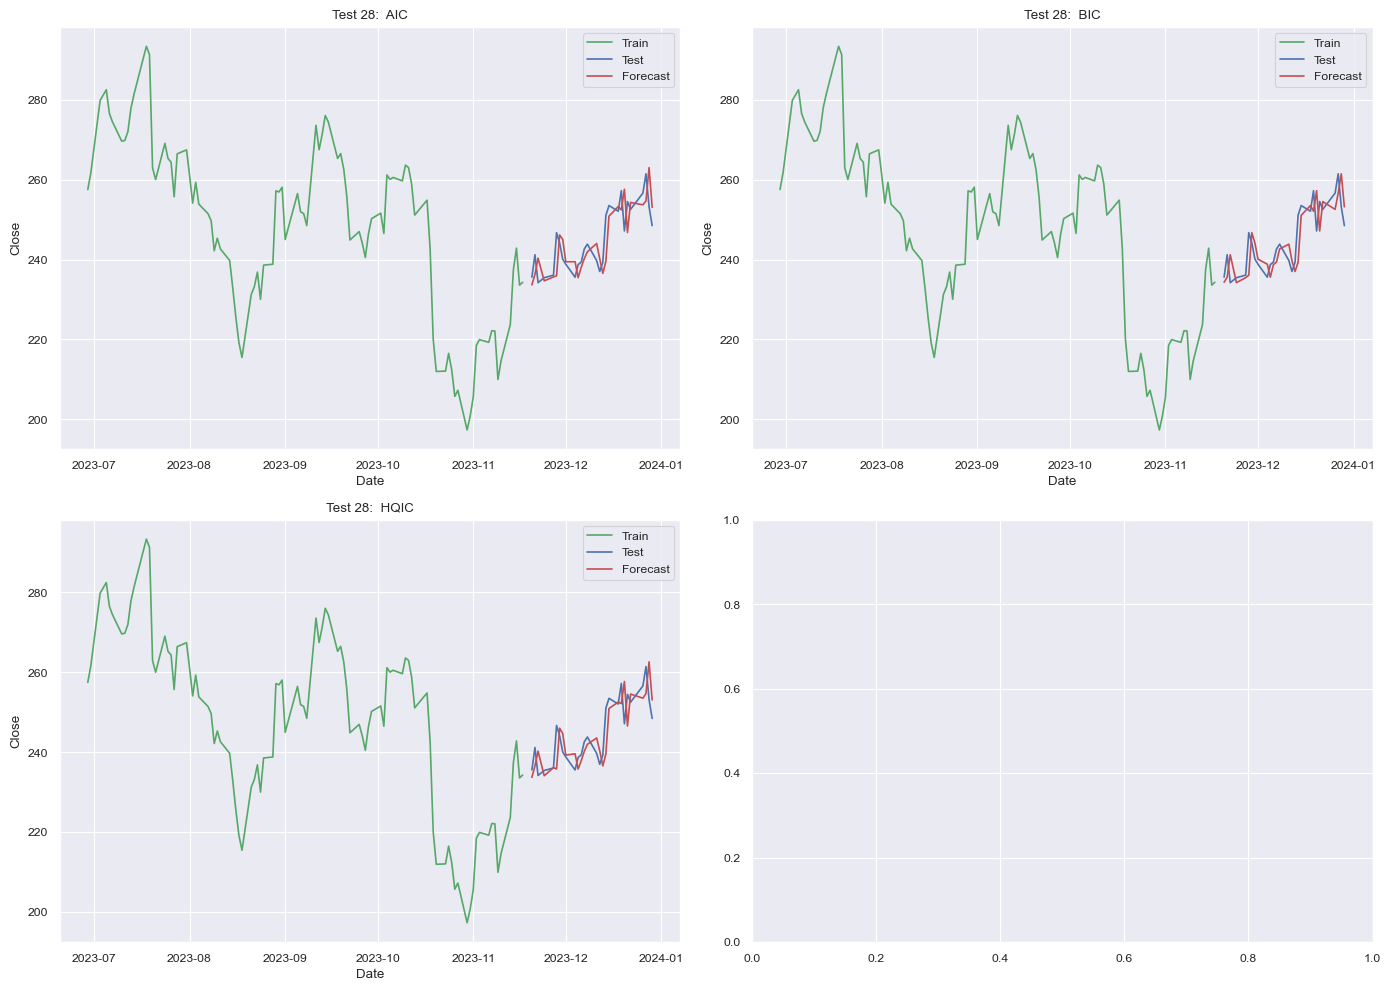

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 0])
sns.lineplot(x=dates, y=yhat_4w, label="Forecast", color='r', ax=axes[0, 0])
axes[0, 0].set_title('Test 28:  AIC')

# Gráfico 2
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast", color='r', ax=axes[0, 1])
axes[0, 1].set_title('Test 28:  BIC')

# Gráfico 3
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1, 0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast", color='r', ax=axes[1, 0])
axes[1, 0].set_title('Test 28:  HQIC')

plt.tight_layout()
plt.show()


### Sin rolling

In [27]:
def arima_no_rolling(train, test, best_order):
   
    model = ARIMA(train, order=best_order)
    model_fit = model.fit()
    
    predictions = model_fit.forecast(steps=len(test))
    
    for i in range(len(test)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    
    return predictions


In [28]:
yhat_aic = arima_no_rolling(list(train), test, results['best_order_aic'])

predicted=233.652269, expected=235.600006
predicted=234.396655, expected=241.199997
predicted=233.575445, expected=234.210007
predicted=233.914234, expected=235.449997
predicted=234.204130, expected=236.080002
predicted=233.625709, expected=246.720001
predicted=233.981567, expected=244.139999
predicted=234.100325, expected=240.080002
predicted=233.673542, expected=238.830002
predicted=234.020497, expected=235.580002
predicted=234.018564, expected=238.720001
predicted=233.726375, expected=239.369995
predicted=234.034396, expected=242.639999
predicted=233.959196, expected=243.839996
predicted=233.776837, expected=239.740005
predicted=234.031830, expected=237.009995
predicted=233.919093, expected=239.289993
predicted=233.821064, expected=251.050003
predicted=234.019462, expected=253.500000
predicted=233.894556, expected=252.080002
predicted=233.857283, expected=257.220001
predicted=234.002292, expected=247.139999
predicted=233.881846, expected=254.500000
predicted=233.885171, expected=252

In [29]:
forecast_accuracy(np.array(test), np.array(yhat_aic), "Dias 28")

,MAE,MSE,MAPE,RMSE,R2
Dias 28,10.947664,180.252238,0.046802,13.425805,-1.985656


El modelo `yhat_aic` tiene un desempeño inferior en comparación con los modelos `hqic` y `bic`. Presenta un mayor error absoluto, cuadrático, y relativo (MAE, MSE, MAPE), y el valor de R² es más negativo, lo que sugiere que no está capturando correctamente la tendencia de los datos. En resumen, este modelo es menos efectivo para hacer predicciones precisas que los anteriores.

In [30]:
yhat_bic = arima_no_rolling(list(train), test, results['best_order_bic'])

predicted=234.300003, expected=235.600006
predicted=234.300003, expected=241.199997
predicted=234.300003, expected=234.210007
predicted=234.300003, expected=235.449997
predicted=234.300003, expected=236.080002
predicted=234.300003, expected=246.720001
predicted=234.300003, expected=244.139999
predicted=234.300003, expected=240.080002
predicted=234.300003, expected=238.830002
predicted=234.300003, expected=235.580002
predicted=234.300003, expected=238.720001
predicted=234.300003, expected=239.369995
predicted=234.300003, expected=242.639999
predicted=234.300003, expected=243.839996
predicted=234.300003, expected=239.740005
predicted=234.300003, expected=237.009995
predicted=234.300003, expected=239.289993
predicted=234.300003, expected=251.050003
predicted=234.300003, expected=253.500000
predicted=234.300003, expected=252.080002
predicted=234.300003, expected=257.220001
predicted=234.300003, expected=247.139999
predicted=234.300003, expected=254.500000
predicted=234.300003, expected=252

In [31]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 28")

,MAE,MSE,MAPE,RMSE,R2
Dias 28,10.572139,172.006968,0.045122,13.115143,-1.849084


El modelo yhat_bic muestra una pequeña mejora en todas las métricas (MAE, MSE, MAPE, RMSE y R²), pero la mejora no es significativa. El error sigue siendo relativamente alto en términos absolutos, y el R² negativo indica que el modelo no es adecuado para capturar las tendencias o patrones en los datos. Esto sugiere que el modelo todavía necesita ajustes, posiblemente una revisión en la selección de variables o el tipo de modelo utilizado.

In [32]:
yhat_hqic = arima_no_rolling(list(train), test, results['best_order_hqic'])

predicted=233.721177, expected=235.600006
predicted=234.775835, expected=241.199997
predicted=234.001561, expected=234.210007
predicted=233.974203, expected=235.449997
predicted=234.657091, expected=236.080002
predicted=233.927889, expected=246.720001
predicted=234.154726, expected=244.139999
predicted=234.520487, expected=240.080002
predicted=233.925969, expected=238.830002
predicted=234.272181, expected=235.580002
predicted=234.392696, expected=238.720001
predicted=233.967597, expected=239.369995
predicted=234.334213, expected=242.639999
predicted=234.289202, expected=243.839996
predicted=234.029250, expected=239.740005
predicted=234.353667, expected=237.009995
predicted=234.215712, expected=239.289993
predicted=234.093795, expected=251.050003
predicted=234.344602, expected=253.500000
predicted=234.171203, expected=252.080002
predicted=234.150489, expected=257.220001
predicted=234.319717, expected=247.139999
predicted=234.150753, expected=254.500000
predicted=234.194032, expected=252

In [33]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 28")

,MAE,MSE,MAPE,RMSE,R2
Dias 28,10.65652,173.916493,0.0455,13.18774,-1.880713


Las métricas de error (MAE, MSE, RMSE) indican que, aunque el error porcentual (MAPE) es relativamente bajo (4.55%), hay errores significativos en unidades absolutas.
El R² negativo sugiere que el modelo no es bueno para capturar la relación entre las variables del conjunto de datos, lo que indica que las predicciones del modelo son peores que un simple promedio de los valores pasados.

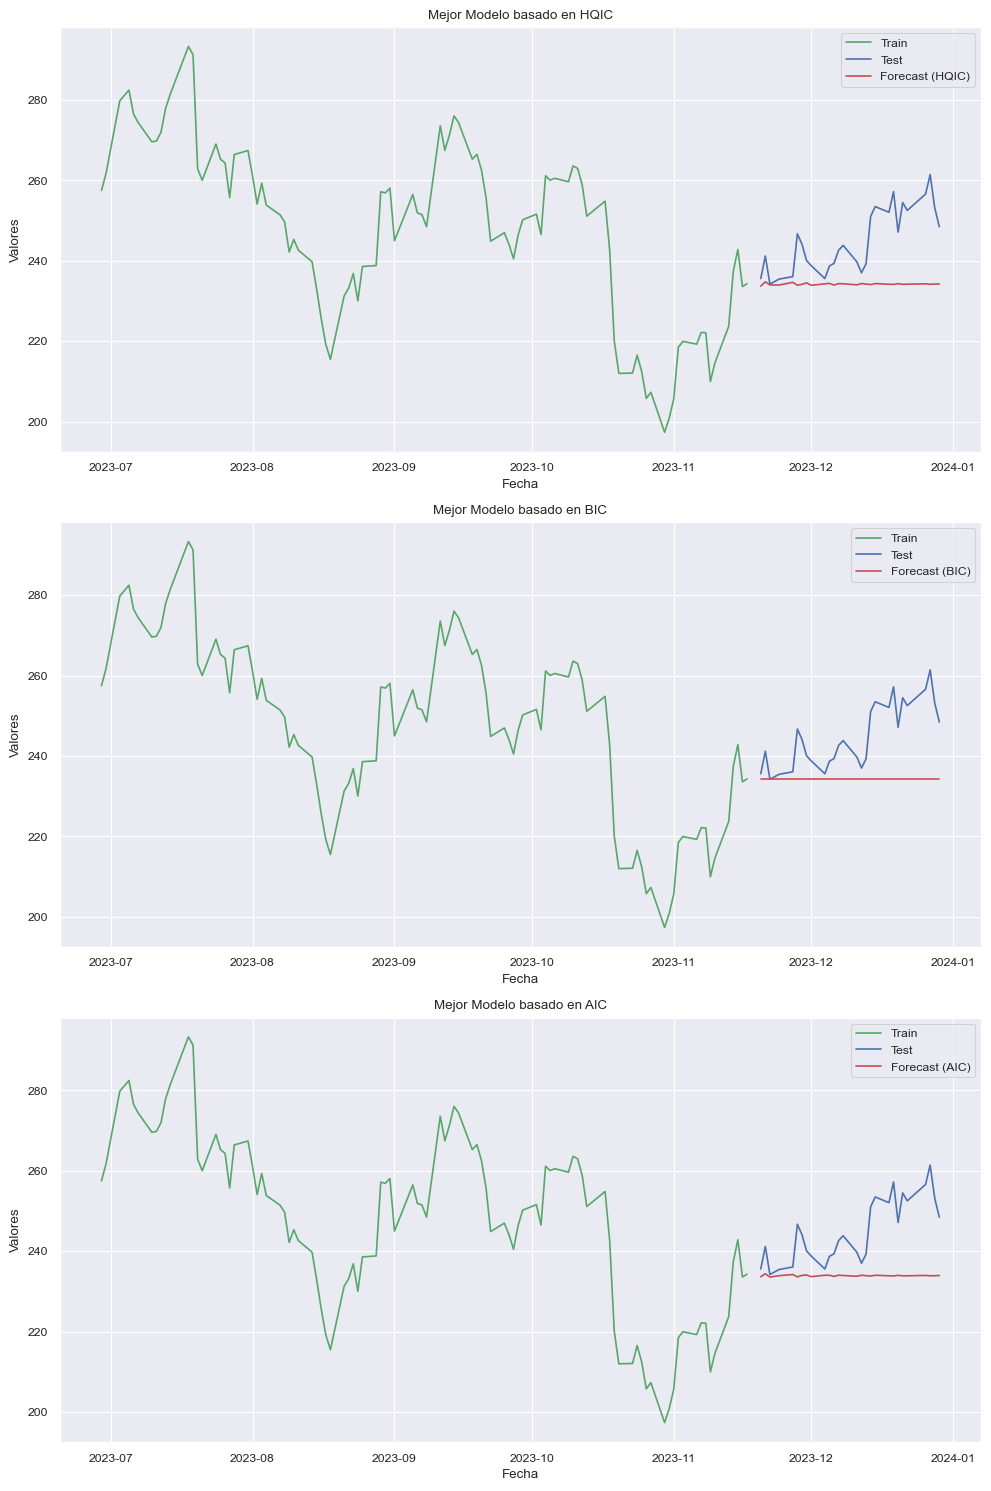

In [34]:

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[2])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[2])
sns.lineplot(x=dates, y=yhat_aic, label="Forecast (AIC)", color='r', ax=axes[2])
axes[2].set_title('Mejor Modelo basado en AIC')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Valores')


sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast (BIC)", color='r', ax=axes[1])
axes[1].set_title('Mejor Modelo basado en BIC')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valores')

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast (HQIC)", color='r', ax=axes[0])
axes[0].set_title('Mejor Modelo basado en HQIC')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valores')
# Mostrar los gráficos juntos
plt.tight_layout()
plt.show()


## Test 21: AIC, BIC, HQIC

### Con Rolling

In [35]:
n = len(TSLA_df['Close']); n_test = 21; train_size = n - n_test

train = TSLA_df['Close'][:train_size]
dates_train = TSLA_df.index[:train_size]

test = TSLA_df['Close'][train_size:train_size + n_test] 
dates = TSLA_df.index[train_size:train_size + n_test] 

print("train:", train.shape)
print("test:", test.shape)

train: (985,)
test: (21,)


In [36]:
results = find_best_arima_order(train)
print(f"Mejor orden AIC: {results['best_order_aic']}, AIC: {results['best_aic']}")
print(f"Mejor orden BIC: {results['best_order_bic']}, BIC: {results['best_bic']}")
print(f"Mejor orden HQIC: {results['best_order_hqic']}, HQIC: {results['best_hqic']}")

Mejor orden AIC: (4, 1, 2), AIC: 7019.842165920371
Mejor orden BIC: (0, 1, 0), BIC: 7036.03278055182
Mejor orden HQIC: (3, 1, 2), HQIC: 7031.409228362745


In [37]:
def arima_rolling(history, test, best_order):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [38]:
yhat_4w  = arima_rolling(list(train), test.tolist(), results['best_order_aic'])

predicted=245.029395, expected=240.080002
predicted=239.431214, expected=238.830002
predicted=239.459298, expected=235.580002
predicted=235.447180, expected=238.720001
predicted=238.060975, expected=239.369995
predicted=240.235598, expected=242.639999
predicted=241.932216, expected=243.839996
predicted=244.012068, expected=239.740005
predicted=240.198119, expected=237.009995
predicted=236.525625, expected=239.289993
predicted=239.566337, expected=251.050003
predicted=250.839651, expected=253.500000
predicted=253.252679, expected=252.080002
predicted=252.403087, expected=257.220001
predicted=257.582613, expected=247.139999
predicted=246.756783, expected=254.500000
predicted=254.289285, expected=252.539993
predicted=253.679397, expected=256.609985
predicted=254.686347, expected=261.440002
predicted=262.983419, expected=253.179993
predicted=253.068145, expected=248.479996


In [39]:
yhat_bic = arima_rolling(list(train), test.tolist(), results['best_order_bic'])

predicted=244.139999, expected=240.080002
predicted=240.080002, expected=238.830002
predicted=238.830002, expected=235.580002
predicted=235.580002, expected=238.720001
predicted=238.720001, expected=239.369995
predicted=239.369995, expected=242.639999
predicted=242.639999, expected=243.839996
predicted=243.839996, expected=239.740005
predicted=239.740005, expected=237.009995
predicted=237.009995, expected=239.289993
predicted=239.289993, expected=251.050003
predicted=251.050003, expected=253.500000
predicted=253.500000, expected=252.080002
predicted=252.080002, expected=257.220001
predicted=257.220001, expected=247.139999
predicted=247.139999, expected=254.500000
predicted=254.500000, expected=252.539993
predicted=252.539993, expected=256.609985
predicted=256.609985, expected=261.440002
predicted=261.440002, expected=253.179993
predicted=253.179993, expected=248.479996


In [40]:
yhat_hqic = arima_rolling(list(train), test, results['best_order_hqic'])

predicted=244.732423, expected=240.080002
predicted=239.295331, expected=238.830002
predicted=239.633832, expected=235.580002
predicted=235.804369, expected=238.720001
predicted=237.909977, expected=239.369995
predicted=240.250354, expected=242.639999
predicted=241.980472, expected=243.839996
predicted=243.598377, expected=239.740005
predicted=240.374782, expected=237.009995
predicted=236.602439, expected=239.289993
predicted=239.609979, expected=251.050003
predicted=250.961437, expected=253.500000
predicted=252.580999, expected=252.080002
predicted=252.176987, expected=257.220001
predicted=257.703373, expected=247.139999
predicted=246.571151, expected=254.500000
predicted=254.574356, expected=252.539993
predicted=253.543992, expected=256.609985
predicted=254.728582, expected=261.440002
predicted=262.633807, expected=253.179993
predicted=253.096374, expected=248.479996


In [41]:
forecast_accuracy(np.array(test), np.array(yhat_4w), "Dias 21 AIC")


,MAE,MSE,MAPE,RMSE,R2
Dias 21 AIC,4.413954,28.798235,0.017772,5.366399,0.507949


In [42]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 21 BIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 21 BIC,4.188572,25.859547,0.016885,5.085228,0.55816


In [43]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 21 HQIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 21 HQIC,4.362091,28.488014,0.017565,5.337416,0.51325


Errores (MAE, MSE, RMSE): El modelo BIC muestra el menor error en todas las métricas, lo que indica que es el modelo más preciso para las predicciones a 21 días. El modelo AIC tiene el mayor MAE y MSE, sugiriendo un rendimiento inferior en comparación con los otros modelos.

MAPE: Todos los modelos tienen un MAPE alrededor del 1.7%, lo que indica un error porcentual bajo, aunque el BIC es ligeramente más preciso con el valor más bajo (0.0169).

R²: El modelo BIC tiene el mayor valor de R² (0.558), lo que significa que explica el 55.8% de la variabilidad de los datos. El modelo HQIC le sigue con un valor de 0.513, y el AIC tiene el valor más bajo de 0.508.

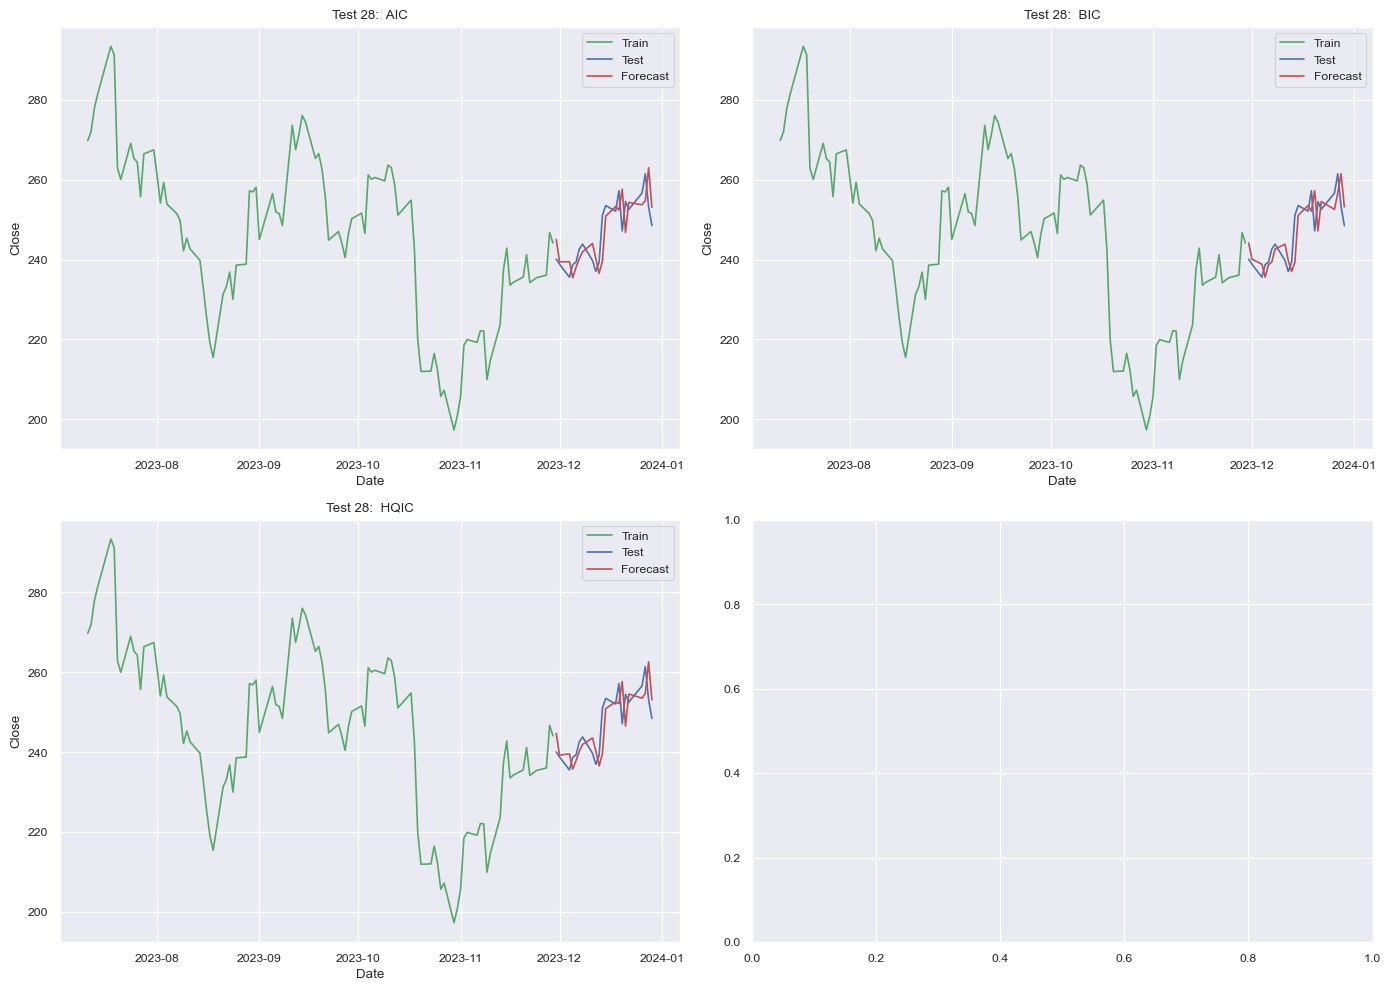

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 0])
sns.lineplot(x=dates, y=yhat_4w, label="Forecast", color='r', ax=axes[0, 0])
axes[0, 0].set_title('Test 28:  AIC')

# Gráfico 2
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast", color='r', ax=axes[0, 1])
axes[0, 1].set_title('Test 28:  BIC')

# Gráfico 3
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1, 0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast", color='r', ax=axes[1, 0])
axes[1, 0].set_title('Test 28:  HQIC')

plt.tight_layout()
plt.show()

### Sin Rolling

In [45]:
yhat_aic = arima_no_rolling(list(train), test, results['best_order_aic'])

predicted=245.029395, expected=240.080002
predicted=244.299883, expected=238.830002
predicted=245.008801, expected=235.580002
predicted=244.674553, expected=238.720001
predicted=244.494143, expected=239.369995
predicted=244.944664, expected=242.639999
predicted=244.632192, expected=243.839996
predicted=244.576077, expected=239.740005
predicted=244.900151, expected=237.009995
predicted=244.607757, expected=239.289993
predicted=244.639931, expected=251.050003
predicted=244.853734, expected=253.500000
predicted=244.602405, expected=252.080002
predicted=244.684820, expected=257.220001
predicted=244.811220, expected=247.139999
predicted=244.608959, expected=254.500000
predicted=244.713945, expected=252.539993
predicted=244.775144, expected=256.609985
predicted=244.622114, expected=261.440002
predicted=244.730699, expected=253.179993
predicted=244.746446, expected=248.479996


In [46]:
forecast_accuracy(np.array(test), np.array(yhat_aic), "Dias 21")

,MAE,MSE,MAPE,RMSE,R2
Dias 21,7.048485,63.167696,0.028803,7.947811,-0.079292


El modelo `yhat_aic` tiene un rendimiento considerablemente mejor en un horizonte de 21 días comparado con el de 28 días. Los errores absolutos y relativos (MAE, MSE, MAPE, RMSE) son significativamente más bajos, lo que indica que las predicciones a corto plazo son más precisas. Aunque el R² sigue siendo negativo, está mucho más cerca de cero, lo que sugiere que el modelo es menos deficiente en este rango de predicción.

In [47]:
yhat_bic = arima_no_rolling(list(train), test, results['best_order_bic'])

predicted=244.139999, expected=240.080002
predicted=244.139999, expected=238.830002
predicted=244.139999, expected=235.580002
predicted=244.139999, expected=238.720001
predicted=244.139999, expected=239.369995
predicted=244.139999, expected=242.639999
predicted=244.139999, expected=243.839996
predicted=244.139999, expected=239.740005
predicted=244.139999, expected=237.009995
predicted=244.139999, expected=239.289993
predicted=244.139999, expected=251.050003
predicted=244.139999, expected=253.500000
predicted=244.139999, expected=252.080002
predicted=244.139999, expected=257.220001
predicted=244.139999, expected=247.139999
predicted=244.139999, expected=254.500000
predicted=244.139999, expected=252.539993
predicted=244.139999, expected=256.609985
predicted=244.139999, expected=261.440002
predicted=244.139999, expected=253.179993
predicted=244.139999, expected=248.479996


In [48]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 21")

,MAE,MSE,MAPE,RMSE,R2
Dias 21,7.071428,65.612718,0.028965,8.100168,-0.121068


El rendimiento del modelo yhat_bic es muy similar al del modelo yhat_aic en el horizonte de 21 días. Aunque el MSE y RMSE son un poco más altos, las diferencias no son significativas, y ambos modelos tienen prácticamente el mismo error absoluto y relativo. El valor de R² negativo indica que el modelo no es ideal para este rango de predicción, aunque los errores son moderados. En general, ambos modelos ofrecen un rendimiento similar para este horizonte.

In [49]:
yhat_hqic = arima_no_rolling(list(train), test, results['best_order_hqic'])

predicted=244.732423, expected=240.080002
predicted=243.858435, expected=238.830002
predicted=244.562527, expected=235.580002
predicted=244.499890, expected=238.720001
predicted=243.977888, expected=239.369995
predicted=244.604902, expected=242.639999
predicted=244.354816, expected=243.839996
predicted=244.101608, expected=239.740005
predicted=244.591033, expected=237.009995
predicted=244.265809, expected=239.289993
predicted=244.211250, expected=251.050003
predicted=244.545383, expected=253.500000
predicted=244.223645, expected=252.080002
predicted=244.296125, expected=257.220001
predicted=244.487511, expected=247.139999
predicted=244.215803, expected=254.500000
predicted=244.353528, expected=252.539993
predicted=244.430947, expected=256.609985
predicted=244.229676, expected=261.440002
predicted=244.385931, expected=253.179993
predicted=244.383595, expected=248.479996


In [50]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 21")

,MAE,MSE,MAPE,RMSE,R2
Dias 21,7.067901,64.847507,0.028926,8.052795,-0.107993


El modelo `yhat_hqic` muestra un desempeño muy parecido al de los modelos `yhat_aic` y `yhat_bic` para el horizonte de 21 días. Los errores absolutos, cuadrados y relativos son comparables entre los tres modelos, con pequeñas diferencias en favor del modelo `yhat_aic` en términos de MSE y RMSE. El valor de R², aunque negativo, es ligeramente mejor que el del modelo `yhat_bic`, sugiriendo que `yhat_hqic` puede tener una ligera ventaja en capturar la variabilidad de los datos en comparación con `yhat_bic`, aunque sigue siendo insuficiente para una buena predicción.

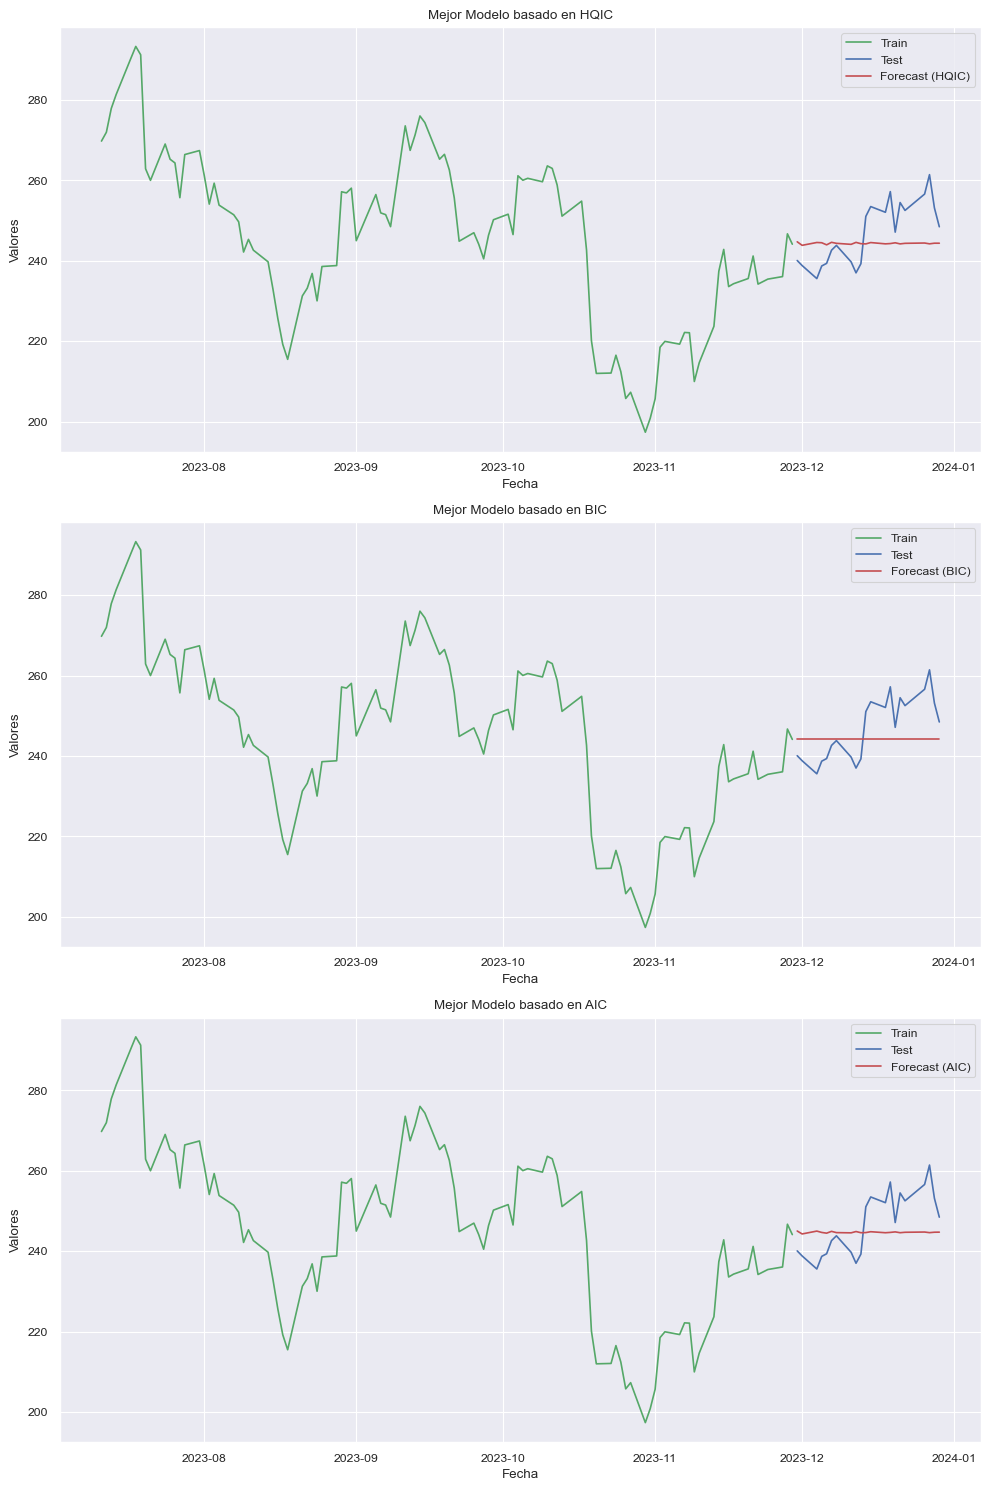

In [51]:

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[2])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[2])
sns.lineplot(x=dates, y=yhat_aic, label="Forecast (AIC)", color='r', ax=axes[2])
axes[2].set_title('Mejor Modelo basado en AIC')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Valores')


sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast (BIC)", color='r', ax=axes[1])
axes[1].set_title('Mejor Modelo basado en BIC')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valores')

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast (HQIC)", color='r', ax=axes[0])
axes[0].set_title('Mejor Modelo basado en HQIC')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valores')
# Mostrar los gráficos juntos
plt.tight_layout()
plt.show()

## Test 14: AIC, BIC, HQIC

### Con Rolling

In [52]:
n = len(TSLA_df['Close']); n_test = 14; train_size = n - n_test

train = TSLA_df['Close'][:train_size]
dates_train = TSLA_df.index[:train_size]

test = TSLA_df['Close'][train_size:train_size + n_test] 
dates = TSLA_df.index[train_size:train_size + n_test] 

print("train:", train.shape)
print("test:", test.shape)

train: (992,)
test: (14,)


In [53]:
results = find_best_arima_order(train)
print(f"Mejor orden AIC: {results['best_order_aic']}, AIC: {results['best_aic']}")
print(f"Mejor orden BIC: {results['best_order_bic']}, BIC: {results['best_bic']}")
print(f"Mejor orden HQIC: {results['best_order_hqic']}, HQIC: {results['best_hqic']}")

Mejor orden AIC: (4, 1, 2), AIC: 7063.510851961017
Mejor orden BIC: (0, 1, 0), BIC: 7079.71221645658
Mejor orden HQIC: (3, 1, 2), HQIC: 7075.055225505286


In [54]:
yhat_4w  = arima_rolling(list(train), test.tolist(), results['best_order_aic'])

predicted=244.012068, expected=239.740005
predicted=240.198119, expected=237.009995
predicted=236.525625, expected=239.289993
predicted=239.566337, expected=251.050003
predicted=250.839651, expected=253.500000
predicted=253.252679, expected=252.080002
predicted=252.403087, expected=257.220001
predicted=257.582613, expected=247.139999
predicted=246.756783, expected=254.500000
predicted=254.289285, expected=252.539993
predicted=253.679397, expected=256.609985
predicted=254.686347, expected=261.440002
predicted=262.983419, expected=253.179993
predicted=253.068145, expected=248.479996


In [55]:
yhat_bic = arima_rolling(list(train), test, results['best_order_bic'])

predicted=243.839996, expected=239.740005
predicted=239.740005, expected=237.009995
predicted=237.009995, expected=239.289993
predicted=239.289993, expected=251.050003
predicted=251.050003, expected=253.500000
predicted=253.500000, expected=252.080002
predicted=252.080002, expected=257.220001
predicted=257.220001, expected=247.139999
predicted=247.139999, expected=254.500000
predicted=254.500000, expected=252.539993
predicted=252.539993, expected=256.609985
predicted=256.609985, expected=261.440002
predicted=261.440002, expected=253.179993
predicted=253.179993, expected=248.479996


In [56]:
yhat_hqic = arima_rolling(list(train), test, results['best_order_hqic'])

predicted=243.598377, expected=239.740005
predicted=240.374782, expected=237.009995
predicted=236.602439, expected=239.289993
predicted=239.609979, expected=251.050003
predicted=250.961437, expected=253.500000
predicted=252.580999, expected=252.080002
predicted=252.176987, expected=257.220001
predicted=257.703373, expected=247.139999
predicted=246.571151, expected=254.500000
predicted=254.574356, expected=252.539993
predicted=253.543992, expected=256.609985
predicted=254.728582, expected=261.440002
predicted=262.633807, expected=253.179993
predicted=253.096374, expected=248.479996


In [57]:
forecast_accuracy(np.array(test), np.array(yhat_4w), "Dias 14 AIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 14 AIC,5.312079,38.786455,0.021214,6.227877,0.200713


In [58]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 14 AIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 14 AIC,5.081431,35.144778,0.02032,5.928303,0.275758


In [59]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 14 AIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 14 AIC,5.271965,38.582314,0.021061,6.211466,0.20492


Errores (MAE, MSE, RMSE): El modelo BIC muestra el menor MAE, MSE y RMSE, lo que indica que es el modelo más preciso para las predicciones a 14 días. El modelo AIC tiene el mayor MAE y MSE, lo que sugiere un rendimiento inferior en comparación con los otros modelos.

MAPE: Todos los modelos tienen un MAPE alrededor del 2.0%, con el modelo BIC siendo el más preciso al tener el valor más bajo (0.0203).

R²: El modelo BIC también tiene el mayor valor de R² (0.276), lo que significa que explica el 27.6% de la variabilidad de los datos. El modelo HQIC le sigue con un valor de 0.205, y el AIC tiene el valor más bajo de 0.201

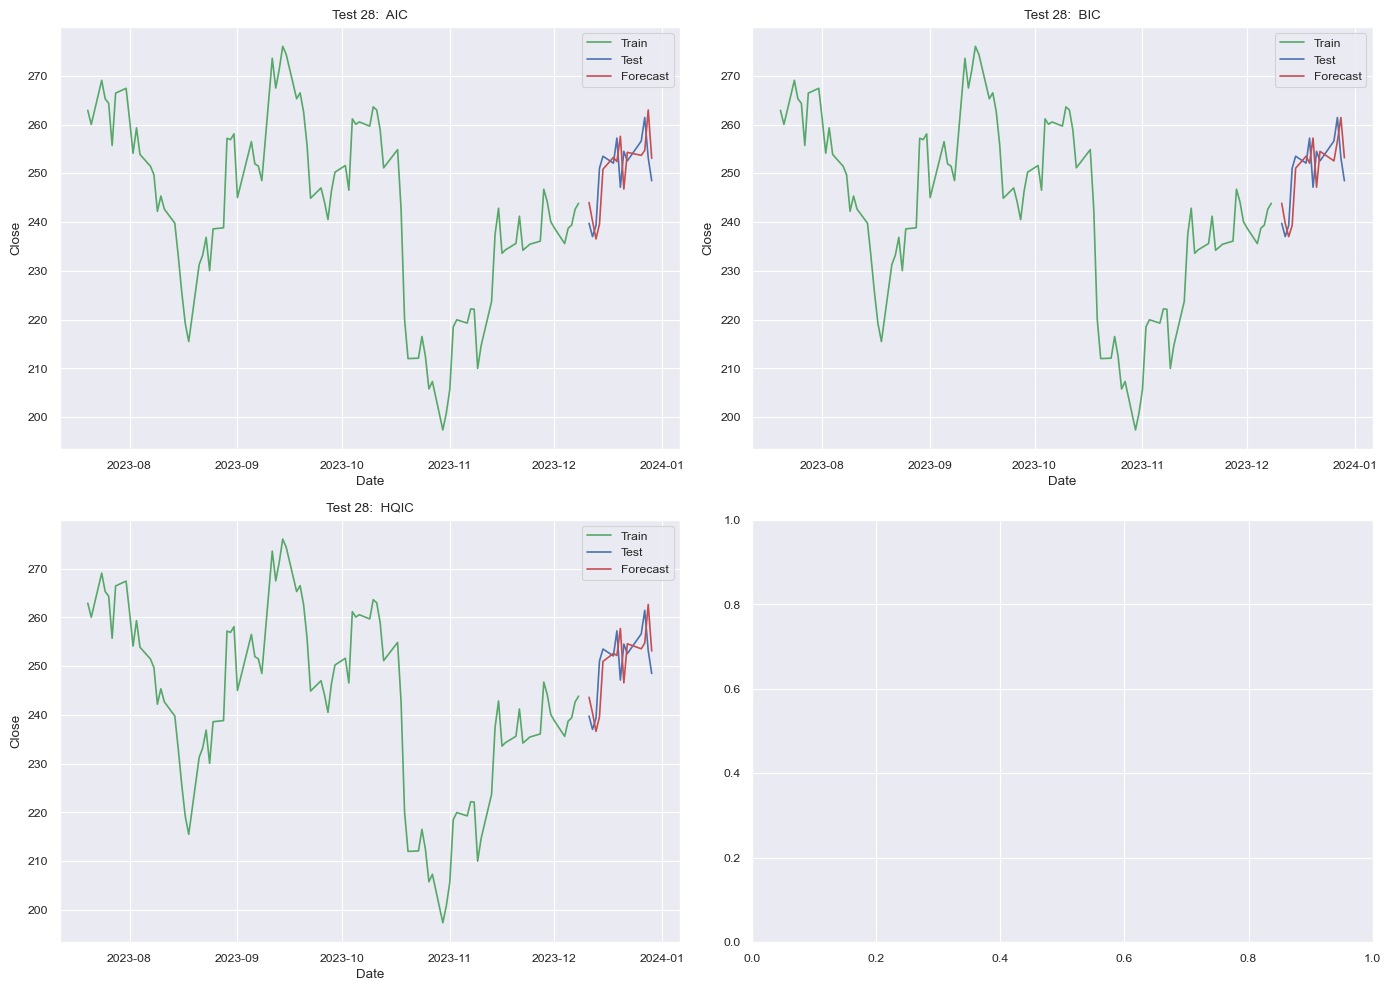

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 0])
sns.lineplot(x=dates, y=yhat_4w, label="Forecast", color='r', ax=axes[0, 0])
axes[0, 0].set_title('Test 28:  AIC')

# Gráfico 2
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast", color='r', ax=axes[0, 1])
axes[0, 1].set_title('Test 28:  BIC')

# Gráfico 3
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1, 0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast", color='r', ax=axes[1, 0])
axes[1, 0].set_title('Test 28:  HQIC')

plt.tight_layout()
plt.show()

### Sin Rolling

In [61]:
yhat_aic = arima_no_rolling(list(train), test, results['best_order_aic'])

predicted=244.012068, expected=239.740005
predicted=244.404275, expected=237.009995
predicted=243.948146, expected=239.289993
predicted=244.187372, expected=251.050003
predicted=244.319377, expected=253.500000
predicted=243.984693, expected=252.080002
predicted=244.222940, expected=257.220001
predicted=244.257181, expected=247.139999
predicted=244.019252, expected=254.500000
predicted=244.239854, expected=252.539993
predicted=244.210069, expected=256.609985
predicted=244.054375, expected=261.440002
predicted=244.242925, expected=253.179993
predicted=244.177088, expected=248.479996


In [62]:
forecast_accuracy(np.array(test), np.array(yhat_aic), "Dias 14")

,MAE,MSE,MAPE,RMSE,R2
Dias 14,8.439239,85.851046,0.034564,9.265584,-0.769165


El rendimiento del modelo en el horizonte de 14 días muestra un empeoramiento en comparación con el rendimiento en el horizonte de 21 días. Los errores absolutos, cuadrados y relativos son mayores, indicando que el modelo es menos preciso para las predicciones a 14 días. El valor de R² negativo sugiere que el modelo tiene dificultades significativas para capturar la variabilidad de los datos en este horizonte. En resumen, el modelo yhat_aic tiene un desempeño peor a corto plazo (14 días) en comparación con el de 21 días.

In [63]:
yhat_bic = arima_no_rolling(list(train), test, results['best_order_bic'])

predicted=243.839996, expected=239.740005
predicted=243.839996, expected=237.009995
predicted=243.839996, expected=239.289993
predicted=243.839996, expected=251.050003
predicted=243.839996, expected=253.500000
predicted=243.839996, expected=252.080002
predicted=243.839996, expected=257.220001
predicted=243.839996, expected=247.139999
predicted=243.839996, expected=254.500000
predicted=243.839996, expected=252.539993
predicted=243.839996, expected=256.609985
predicted=243.839996, expected=261.440002
predicted=243.839996, expected=253.179993
predicted=243.839996, expected=248.479996


In [64]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 14")

,MAE,MSE,MAPE,RMSE,R2
Dias 14,8.641429,89.871219,0.035439,9.480043,-0.85201


El modelo `yhat_bic` muestra un desempeño peor en el horizonte de 14 días en comparación con el modelo `yhat_aic`. Los errores absolutos, cuadrados y relativos son mayores, y el valor de R² es más bajo, lo que indica que el modelo tiene una menor capacidad para predecir con precisión y explicar la variabilidad en los datos. En resumen, `yhat_bic` es menos preciso y tiene un desempeño menos satisfactorio en las predicciones a corto plazo (14 días) en comparación con `yhat_aic`.

In [65]:
yhat_hqic = arima_no_rolling(list(train), test, results['best_order_hqic'])

predicted=243.598377, expected=239.740005
predicted=244.161472, expected=237.009995
predicted=243.614542, expected=239.289993
predicted=243.754502, expected=251.050003
predicted=244.060518, expected=253.500000
predicted=243.605885, expected=252.080002
predicted=243.847983, expected=257.220001
predicted=243.965083, expected=247.139999
predicted=243.632030, expected=254.500000
predicted=243.899715, expected=252.539993
predicted=243.886109, expected=256.609985
predicted=243.675289, expected=261.440002
predicted=243.918731, expected=253.179993
predicted=243.828696, expected=248.479996


In [66]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 14")

,MAE,MSE,MAPE,RMSE,R2
Dias 14,8.642845,90.386926,0.035448,9.507204,-0.862638


yhat_hqic muestra el peor desempeño en el horizonte de 14 días en comparación con los modelos yhat_aic y yhat_bic. Los errores absolutos, cuadrados y relativos son mayores, y el valor de R² es el más bajo, lo que sugiere que el yhat_hqic tiene la menor precisión y capacidad explicativa para las predicciones a corto plazo. En resumen, el modelo yhat_hqic es el menos eficaz entre los tres en este horizonte de predicción.

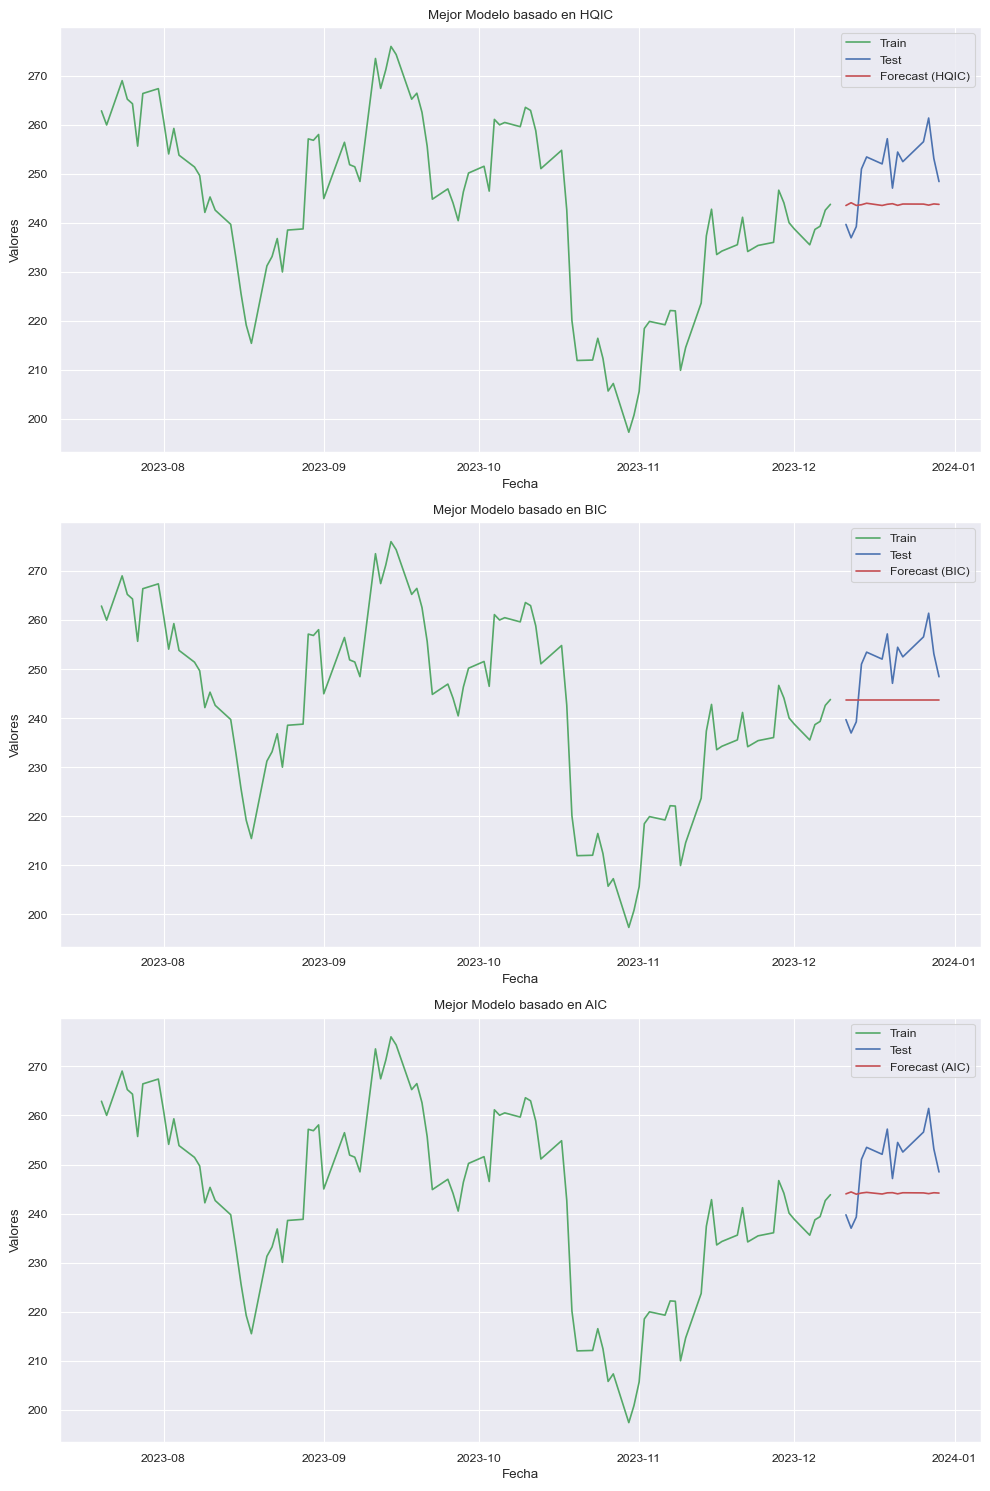

In [67]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[2])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[2])
sns.lineplot(x=dates, y=yhat_aic, label="Forecast (AIC)", color='r', ax=axes[2])
axes[2].set_title('Mejor Modelo basado en AIC')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Valores')


sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast (BIC)", color='r', ax=axes[1])
axes[1].set_title('Mejor Modelo basado en BIC')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valores')

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast (HQIC)", color='r', ax=axes[0])
axes[0].set_title('Mejor Modelo basado en HQIC')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valores')
# Mostrar los gráficos juntos
plt.tight_layout()
plt.show()

## Test 7: AIC, BIC, HQIC

### Con Rolling

In [68]:
n = len(TSLA_df['Close']); n_test = 7; train_size = n - n_test

train = TSLA_df['Close'][:train_size]
dates_train = TSLA_df.index[:train_size]

test = TSLA_df['Close'][train_size:train_size + n_test] 
dates = TSLA_df.index[train_size:train_size + n_test] 

print("train:", train.shape)
print("test:", test.shape)

train: (999,)
test: (7,)


In [69]:
results = find_best_arima_order(train)
print(f"Mejor orden AIC: {results['best_order_aic']}, AIC: {results['best_aic']}")
print(f"Mejor orden BIC: {results['best_order_bic']}, BIC: {results['best_bic']}")
print(f"Mejor orden HQIC: {results['best_order_hqic']}, HQIC: {results['best_hqic']}")

Mejor orden AIC: (4, 1, 2), AIC: 7109.067757459991
Mejor orden BIC: (0, 1, 0), BIC: 7125.415298906486
Mejor orden HQIC: (3, 1, 2), HQIC: 7120.5891919022615


In [70]:
yhat_4w  = arima_rolling(list(train), test, results['best_order_aic'])

predicted=257.582613, expected=247.139999
predicted=246.756783, expected=254.500000
predicted=254.289285, expected=252.539993
predicted=253.679397, expected=256.609985
predicted=254.686347, expected=261.440002
predicted=262.983419, expected=253.179993
predicted=253.068145, expected=248.479996


In [71]:
yhat_bic  = arima_rolling(list(train), test, results['best_order_bic'])

predicted=257.220001, expected=247.139999
predicted=247.139999, expected=254.500000
predicted=254.500000, expected=252.539993
predicted=252.539993, expected=256.609985
predicted=256.609985, expected=261.440002
predicted=261.440002, expected=253.179993
predicted=253.179993, expected=248.479996


In [72]:
yhat_hqic  = arima_rolling(list(train), test, results['best_order_hqic'])

predicted=257.703373, expected=247.139999
predicted=246.571151, expected=254.500000
predicted=254.574356, expected=252.539993
predicted=253.543992, expected=256.609985
predicted=254.728582, expected=261.440002
predicted=262.633807, expected=253.179993
predicted=253.096374, expected=248.479996


In [73]:
forecast_accuracy(np.array(test), np.array(yhat_4w), "Dias 7 AIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 7 AIC,6.287277,49.060587,0.024611,7.004326,-1.447147


In [74]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 7 BIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 7 BIC,5.894289,41.404186,0.02311,6.434608,-1.065245


In [75]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 7 HQIC")

,MAE,MSE,MAPE,RMSE,R2
Dias 7 HQIC,6.33917,49.102741,0.024831,7.007335,-1.449249


Errores (MAE, MSE, RMSE): El modelo BIC tiene el menor MAE (5.89), MSE (41.40) y RMSE (6.43), lo que sugiere que es el modelo más preciso para las predicciones a 7 días. En comparación, el modelo AIC presenta un MAE y MSE más altos, indicando un rendimiento inferior.

MAPE: Todos los modelos tienen un MAPE superior al 2.0%, con el modelo BIC nuevamente mostrando el valor más bajo (0.0231), lo que indica que ofrece mejores predicciones en términos porcentuales.

R²: Los valores de R² son negativos, lo que indica que ninguno de los modelos logra explicar la variabilidad de los datos en este caso. Sin embargo, el modelo BIC tiene el valor más alto (-1.065), lo que sugiere que es el mejor de los tres en términos de ajuste.

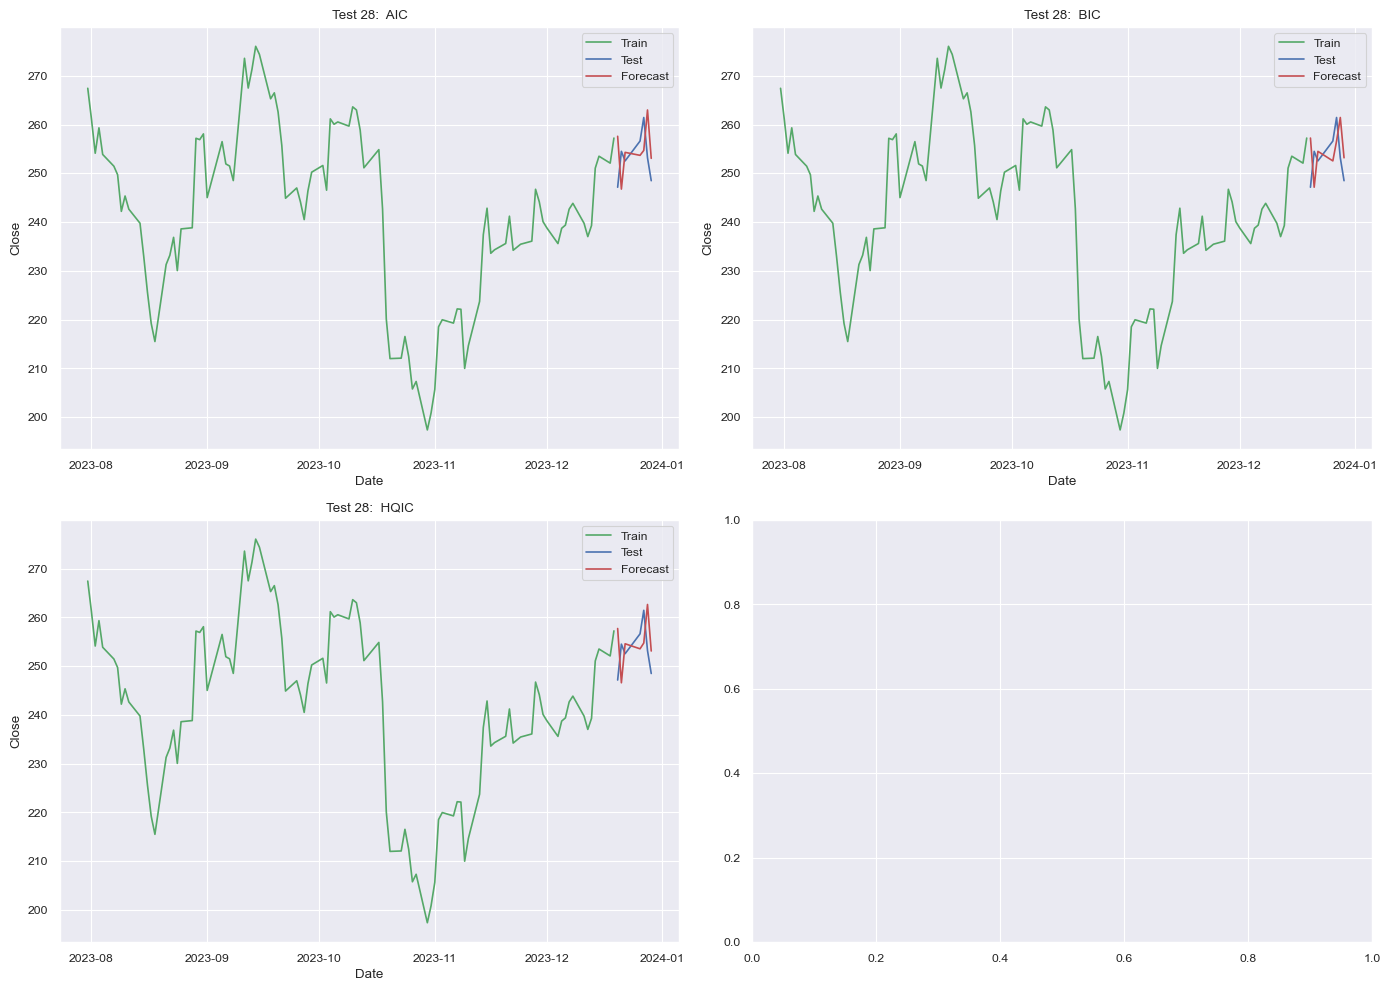

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 0])
sns.lineplot(x=dates, y=yhat_4w, label="Forecast", color='r', ax=axes[0, 0])
axes[0, 0].set_title('Test 28:  AIC')

# Gráfico 2
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0, 1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0, 1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast", color='r', ax=axes[0, 1])
axes[0, 1].set_title('Test 28:  BIC')

# Gráfico 3
sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1, 0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1, 0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast", color='r', ax=axes[1, 0])
axes[1, 0].set_title('Test 28:  HQIC')

plt.tight_layout()
plt.show()

### Sin Rolling

In [77]:
yhat_aic = arima_no_rolling(list(train), test, results['best_order_aic'])

predicted=257.582613, expected=247.139999
predicted=257.044687, expected=254.500000
predicted=257.138419, expected=252.539993
predicted=257.786311, expected=256.609985
predicted=256.985246, expected=261.440002
predicted=257.300099, expected=253.179993
predicted=257.642905, expected=248.479996


In [78]:
forecast_accuracy(np.array(test), np.array(yhat_aic), "Dias 7")

,MAE,MSE,MAPE,RMSE,R2
Dias 7,5.214261,36.975987,0.020257,6.080788,-0.844366


El modelo `yhat_aic` tiene un error absoluto y relativo bajo en un horizonte de 7 días, lo que indica que las predicciones no están muy lejos de los valores reales. Sin embargo, el valor de R² negativo sugiere que, a pesar de los bajos errores, el modelo no captura adecuadamente la estructura de los datos, por lo que sus predicciones no son muy confiables a nivel explicativo. Esto podría indicar que el modelo es adecuado para la predicción en términos de precisión, pero no refleja bien la variabilidad de los datos subyacentes.

In [79]:
yhat_bic = arima_no_rolling(list(train), test, results['best_order_bic'])

predicted=257.220001, expected=247.139999
predicted=257.220001, expected=254.500000
predicted=257.220001, expected=252.539993
predicted=257.220001, expected=256.609985
predicted=257.220001, expected=261.440002
predicted=257.220001, expected=253.179993
predicted=257.220001, expected=248.479996


In [80]:
forecast_accuracy(np.array(test), np.array(yhat_bic), "Dias 7")

,MAE,MSE,MAPE,RMSE,R2
Dias 7,5.012863,34.542459,0.019489,5.877283,-0.722981


Muestra una ligera mejora respecto al modelo anterior en términos de error absoluto (MAE), error cuadrático (MSE y RMSE), y error porcentual (MAPE), lo que sugiere que es más preciso para las predicciones en un horizonte de 7 días. Sin embargo, el R² negativo indica que, aunque es mejor que el modelo anterior, aún no logra captar adecuadamente la estructura de los datos. Esto sugiere que este modelo es más efectivo en términos de precisión, pero todavía no puede explicar bien la variabilidad subyacente en los datos.

In [81]:
yhat_hqic = arima_no_rolling(list(train), test, results['best_order_hqic'])

predicted=257.703373, expected=247.139999
predicted=256.941555, expected=254.500000
predicted=256.961438, expected=252.539993
predicted=257.622368, expected=256.609985
predicted=256.874713, expected=261.440002
predicted=257.140611, expected=253.179993
predicted=257.477887, expected=248.479996


In [82]:
forecast_accuracy(np.array(test), np.array(yhat_hqic), "Dias 7")

,MAE,MSE,MAPE,RMSE,R2
Dias 7,5.137508,36.515794,0.019964,6.04283,-0.821411


El modelo yhat_hqic es menos preciso y tiene menos capacidad para explicar la variabilidad de los datos que el modelo yhat_bic.

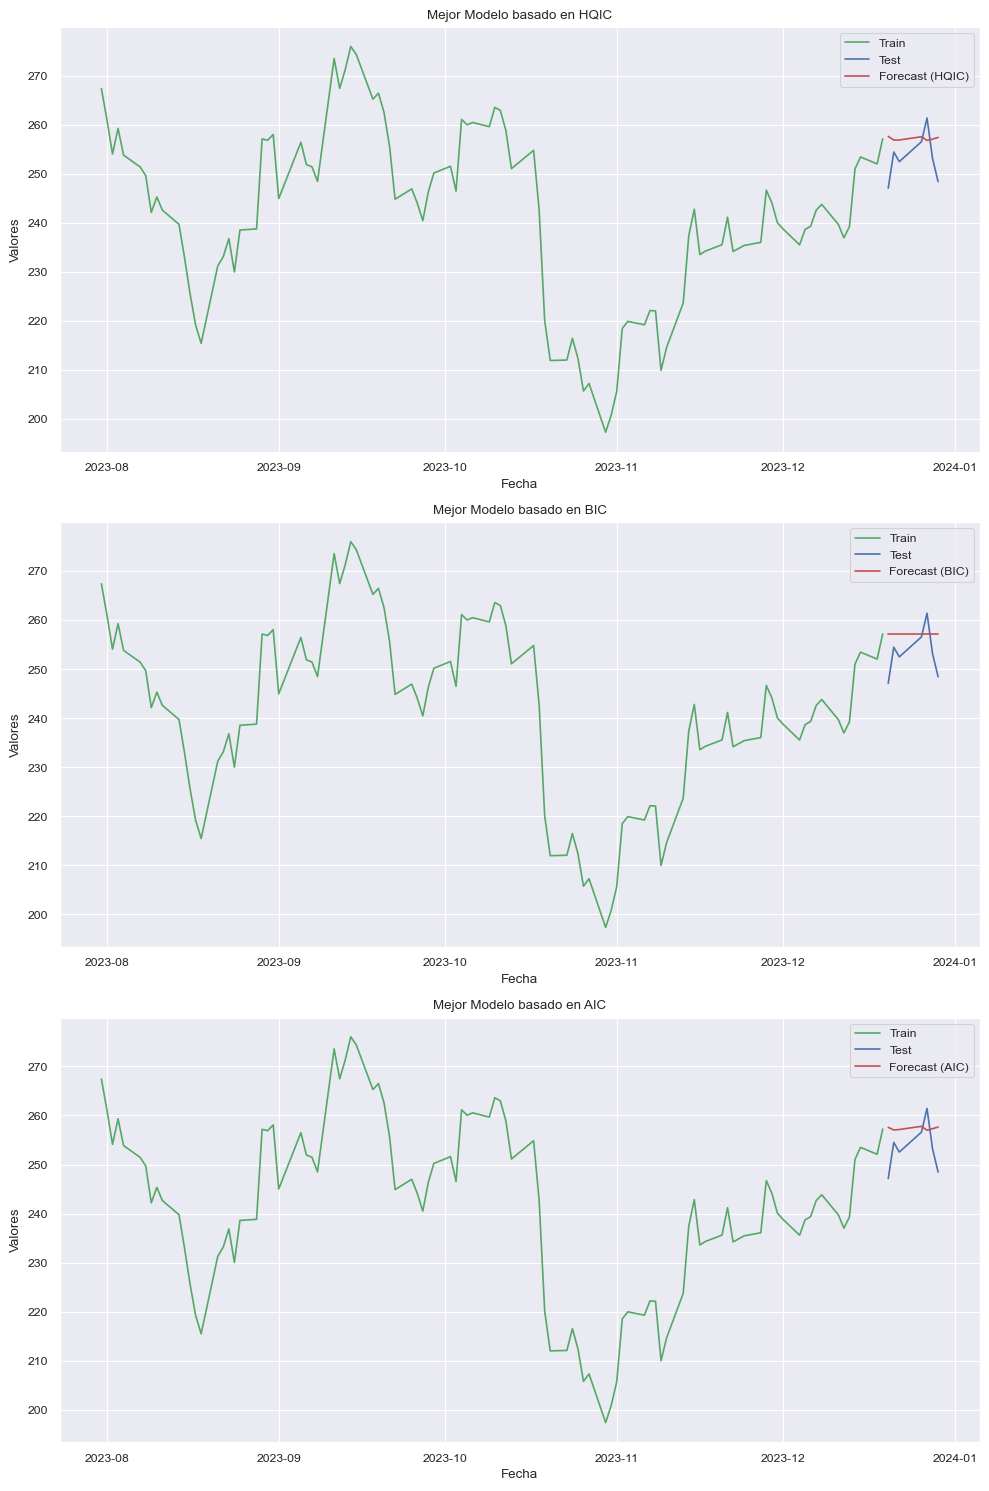

In [83]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[2])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[2])
sns.lineplot(x=dates, y=yhat_aic, label="Forecast (AIC)", color='r', ax=axes[2])
axes[2].set_title('Mejor Modelo basado en AIC')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Valores')


sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[1])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[1])
sns.lineplot(x=dates, y=yhat_bic, label="Forecast (BIC)", color='r', ax=axes[1])
axes[1].set_title('Mejor Modelo basado en BIC')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valores')

sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g', ax=axes[0])
sns.lineplot(x=dates, y=test, label="Test", color='b', ax=axes[0])
sns.lineplot(x=dates, y=yhat_hqic, label="Forecast (HQIC)", color='r', ax=axes[0])
axes[0].set_title('Mejor Modelo basado en HQIC')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valores')
# Mostrar los gráficos juntos
plt.tight_layout()
plt.show()

# Conclusiones


1. **Comparación entre Modelos sin Rolling y con Rolling:**
   - **Modelos sin Rolling:** Los resultados de los modelos ARIMA sin rolling mostraron errores (MAE, MSE, RMSE) relativamente altos, especialmente en los horizontes de predicción más cortos (7 días y 14 días). Esto indica que estos modelos tuvieron dificultades para ajustarse a las variaciones en los datos de precios de las acciones de Tesla.
   - **Modelos con Rolling:** En contraste, los modelos con rolling demostraron un rendimiento significativamente mejor. Los errores fueron más bajos en todos los horizontes de predicción, destacándose el modelo BIC como el más efectivo en los horizontes de 7, 14 y 28 días, con los valores más bajos de MAE y MSE.

2. **Efectividad de los Modelos:**
   - El **modelo BIC** fue consistentemente el mejor en todas las evaluaciones, tanto con como sin rolling, sugiriendo que es el más adecuado para predecir las acciones de Tesla. 
   - Los modelos AIC y HQIC también proporcionaron resultados aceptables, pero no alcanzaron el mismo nivel de precisión que el modelo BIC, especialmente en los horizontes de 28 días.

